**This table will not be combined with inpatient data**

**features**:

num_visits: total number of visits

stay_length: total length of unit stays (use service mean stay length to impute)

num_cvd_diagnosis: number of readmissions that are caused by cardiovascular

CVD: whether the patient has a cardiovescular diagnosis

*Different Age bins*: number of unit stays within this age range

age_mean: the mean admission age for each patient

age_std: the std of the admission age for each patient

AO: whether this patinet has been exposed to Agentorange


In [16]:
import pandas as pd

import numpy as np
import pandas as pd

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import preprocess_data 
from tqdm.auto import tqdm
import math

reload(preprocess_data)

%matplotlib inline

In [17]:
datastype = "train"

In [18]:
if datastype == "train": outpatient_visits = pd.read_csv('/home/bhatti/dataset/VCHAMPS/outpatient_visits_train.csv', index_col=0)

### Drop Combatflag, Ionizingradiationflag, Serviceconnectedflag, Swasiaconditionsflag, Agentorangeflag

In [19]:
outpatient_visits = outpatient_visits.drop([ 'Combatflag', 'Ionizingradiationflag', 'Serviceconnectedflag', 'Swasiaconditionsflag', 'Agentorangeflag'], axis=1)

### Age at visit

Divide to different age bins: (20-40], (40-60], (60-80], (80-100], (100-120]

In [20]:
print(outpatient_visits["Age at visit"].min())
print(outpatient_visits["Age at visit"].max())

11.021683798196282
113.61559909687392


In [21]:
outpatient_visits['Age 00-20'] = [0] * len(outpatient_visits)
outpatient_visits['Age 20-40'] = [0] * len(outpatient_visits)
outpatient_visits['Age 40-60'] = [0] * len(outpatient_visits)
outpatient_visits['Age 60-80'] = [0] * len(outpatient_visits)
outpatient_visits['Age 80-100'] = [0] * len(outpatient_visits)
outpatient_visits['Age 100-120'] = [0] * len(outpatient_visits)
def age_category(data):
    data.loc[(data['Age at visit'] <= 20), 'Age 00-20'] = 1
    data.loc[(data['Age at visit'] > 20) & (data['Age at visit'] <= 40), 'Age 20-40'] = 1
    data.loc[(data['Age at visit'] > 40) & (data['Age at visit'] <= 60), 'Age 40-60'] = 1
    data.loc[(data['Age at visit'] > 60) & (data['Age at visit'] <= 80), 'Age 60-80'] = 1
    data.loc[(data['Age at visit'] > 80) & (data['Age at visit'] <= 100), 'Age 80-100'] = 1
    data.loc[(data['Age at visit'] > 100) & (data['Age at visit'] <= 120), 'Age 100-120'] = 1
    return data
outpatient_visits = age_category(outpatient_visits)
outpatient_visits

,Internalpatientid,Age at visit,Visit start date,First listed diagnosis icd10 subcategory,Second listed diagnosis icd10 subcategory,Stop code,State,Age 00-20,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120
0,1,60.619995,2004-11-17 14:35:36.0,Not specified,Not specified,TELEPHONE/MEDICINE,Indiana,0,0,0,1,0,0
1,1,61.032110,2005-04-17 05:40:07.0,Not specified,Not specified,TELEPHONE TRIAGE,Indiana,0,0,0,1,0,0
2,1,61.907075,2006-03-03 00:51:52.0,Not specified,Not specified,LABORATORY,Indiana,0,0,0,1,0,0
3,1,62.296573,2006-07-23 09:32:16.0,Not specified,Not specified,NO-COUNT,Indiana,0,0,0,1,0,0
4,1,63.632066,2007-11-23 12:28:48.0,Not specified,Not specified,GENERAL INTERNAL MEDICINE,Indiana,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105227069,99999,96.300251,2013-03-19 17:47:55.0,Not specified,Not specified,TELEPHONE/ANCILLARY,Arizona,0,0,0,0,1,0
105227070,99999,96.322523,2013-03-27 21:10:33.0,Not specified,Not specified,NEUROLOGY,Arizona,0,0,0,0,1,0
105227071,99999,96.327503,2013-03-29 16:51:35.0,Not specified,Not specified,RENAL/NEPHROL(EXCEPT DIALYSIS),Arizona,0,0,0,0,1,0
105227072,99999,96.360092,2013-04-10 14:43:53.0,Not specified,Not specified,SPEECH-LANGUAGE PATHOLOGY,Arizona,0,0,0,0,1,0


### Cardiovascular

In [22]:
cardiovascular = ["Heart failure, unspecified", "Other heart failure",
                  "Cardiogenic shock", "Hypertensive heart disease with heart failure",
                  "Hypertensive heart and kidney disease with heart failure", "Unstable angina", "Other forms of chronic ischemic heart disease",
                  "Atherosclerotic heart disease of native coronary artery", "Atrial fibrillation", "Atrial flutter",
                  "Supraventricular tachycardia", "Ventricular tachycardia"]

In [23]:
outpatient_visits["CVD_outpatient"] = [0] * len(outpatient_visits)
def cd_diagnosis(data):
    data.loc[(data["Second listed diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | data["Second listed diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | data["Second listed diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | data["Second listed diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | data["Second listed diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | data["Second listed diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)
      | data["First listed diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | data["First listed diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | data["First listed diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | data["First listed diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | data["First listed diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | data["First listed diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)), "CVD_outpatient"] = 1
    return data
outpatient_visits = cd_diagnosis(outpatient_visits)
outpatient_visits


,Internalpatientid,Age at visit,Visit start date,First listed diagnosis icd10 subcategory,Second listed diagnosis icd10 subcategory,Stop code,State,Age 00-20,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120,CVD_outpatient
0,1,60.619995,2004-11-17 14:35:36.0,Not specified,Not specified,TELEPHONE/MEDICINE,Indiana,0,0,0,1,0,0,0
1,1,61.032110,2005-04-17 05:40:07.0,Not specified,Not specified,TELEPHONE TRIAGE,Indiana,0,0,0,1,0,0,0
2,1,61.907075,2006-03-03 00:51:52.0,Not specified,Not specified,LABORATORY,Indiana,0,0,0,1,0,0,0
3,1,62.296573,2006-07-23 09:32:16.0,Not specified,Not specified,NO-COUNT,Indiana,0,0,0,1,0,0,0
4,1,63.632066,2007-11-23 12:28:48.0,Not specified,Not specified,GENERAL INTERNAL MEDICINE,Indiana,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105227069,99999,96.300251,2013-03-19 17:47:55.0,Not specified,Not specified,TELEPHONE/ANCILLARY,Arizona,0,0,0,0,1,0,0
105227070,99999,96.322523,2013-03-27 21:10:33.0,Not specified,Not specified,NEUROLOGY,Arizona,0,0,0,0,1,0,0
105227071,99999,96.327503,2013-03-29 16:51:35.0,Not specified,Not specified,RENAL/NEPHROL(EXCEPT DIALYSIS),Arizona,0,0,0,0,1,0,0
105227072,99999,96.360092,2013-04-10 14:43:53.0,Not specified,Not specified,SPEECH-LANGUAGE PATHOLOGY,Arizona,0,0,0,0,1,0,0


In [24]:
outpatient_visits.columns

Index(['Internalpatientid', 'Age at visit', 'Visit start date',
       'First listed diagnosis icd10 subcategory',
       'Second listed diagnosis icd10 subcategory', 'Stop code', 'State',
       'Age 00-20', 'Age 20-40', 'Age 40-60', 'Age 60-80', 'Age 80-100',
       'Age 100-120', 'CVD_outpatient'],
      dtype='object')

In [25]:
outpatient_visits = outpatient_visits.drop(['First listed diagnosis icd10 subcategory', 'Second listed diagnosis icd10 subcategory'], axis=1)

#### Look into relationship

In [26]:
ed = pd.read_csv("/home/bhatti/dataset/VCHAMPS/ed_visits_train.csv", index_col=0)
in_ad = pd.read_csv("/home/bhatti/dataset/VCHAMPS/inpatient_admissions_train.csv", index_col=0)

In [27]:
print("These patients are in outpatient dataset but not in ed_visits")
print(list(set(outpatient_visits["Internalpatientid"].unique()) - set(ed["Internalpatientid"].unique())))

print("These patients are in ed dataset but not in outpatient")
print(list(set(ed["Internalpatientid"].unique()) - set(outpatient_visits["Internalpatientid"].unique())))

temp = set(outpatient_visits["Internalpatientid"].unique()) - set(ed["Internalpatientid"].unique())
x = temp - set(in_ad["Internalpatientid"].unique())
print(len(x))

These patients are in outpatient dataset but not in ed_visits


[131073, 3, 5, 131077, 131078, 131079, 131080, 131082, 131083, 131085, 14, 131086, 131087, 131088, 18, 131089, 20, 21, 131091, 26, 27, 131101, 131103, 32, 33, 34, 131105, 36, 131108, 131109, 131110, 40, 131112, 43, 131115, 45, 46, 47, 48, 49, 131116, 131117, 131118, 131120, 54, 131121, 56, 57, 58, 61, 131134, 63, 131135, 131136, 131139, 68, 69, 70, 131141, 72, 131142, 74, 131143, 131144, 77, 131145, 79, 80, 131146, 131147, 131149, 131152, 85, 86, 87, 131154, 89, 131155, 91, 131156, 93, 94, 95, 96, 131163, 131165, 131167, 131171, 101, 102, 131172, 131175, 131176, 131178, 111, 113, 114, 115, 131186, 131188, 131190, 131191, 121, 131193, 123, 131195, 125, 131196, 131199, 129, 131203, 132, 133, 134, 131206, 136, 144, 131216, 131217, 131219, 148, 149, 131221, 131223, 154, 131227, 131228, 131229, 158, 163, 164, 131236, 166, 131237, 168, 131239, 131240, 172, 173, 174, 175, 131248, 177, 131249, 179, 131250, 181, 182, 131252, 131253, 185, 131254, 187, 188, 189, 190, 131255, 192, 193, 194, 131267

In [28]:
print(ed["Internalpatientid"].nunique())
print(in_ad["Internalpatientid"].nunique())
print(outpatient_visits["Internalpatientid"].nunique())

58240
84536
133252


#### Filter out visits that occur after death

In [29]:
if datastype == "train": death = pd.read_csv("/home/bhatti/dataset/VCHAMPS/death_train.csv", index_col=0)

In [31]:
outpatient_visits = outpatient_visits.merge(death, how="left",on="Internalpatientid")
outpatient_visits['Visit start date'] = pd.to_datetime(outpatient_visits['Visit start date'])
outpatient_visits['Death date'] = pd.to_datetime(outpatient_visits['Death date'])
outpatient_visits = outpatient_visits[~(outpatient_visits["Visit start date"] > outpatient_visits['Death date'])]

In [34]:
outpatient_visits

,Internalpatientid,Age at visit,Visit start date,Stop code,State,Age 00-20,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120,CVD_outpatient,Age at death,Death date,Died
0,1,60.619995,2004-11-17 14:35:36,TELEPHONE/MEDICINE,Indiana,0,0,0,1,0,0,0,NaN,NaT,0
1,1,61.032110,2005-04-17 05:40:07,TELEPHONE TRIAGE,Indiana,0,0,0,1,0,0,0,NaN,NaT,0
2,1,61.907075,2006-03-03 00:51:52,LABORATORY,Indiana,0,0,0,1,0,0,0,NaN,NaT,0
3,1,62.296573,2006-07-23 09:32:16,NO-COUNT,Indiana,0,0,0,1,0,0,0,NaN,NaT,0
4,1,63.632066,2007-11-23 12:28:48,GENERAL INTERNAL MEDICINE,Indiana,0,0,0,1,0,0,0,NaN,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82692714,99999,96.022967,2012-12-08 09:28:02,WARD STOP CODE,Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1
82692715,99999,96.300251,2013-03-19 17:47:55,TELEPHONE/ANCILLARY,Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1
82692716,99999,96.322523,2013-03-27 21:10:33,NEUROLOGY,Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1
82692717,99999,96.327503,2013-03-29 16:51:35,RENAL/NEPHROL(EXCEPT DIALYSIS),Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1


In [33]:
outpatient_visits["Died"] = [1] * len(outpatient_visits)
outpatient_visits.loc[outpatient_visits["Death date"].isna(), "Died"] = 0

In [36]:
outpatient_visits['Visit start date'] = pd.to_datetime(outpatient_visits['Visit start date'])
outpatient_visits['Death date'] = pd.to_datetime(outpatient_visits['Death date'])
outpatient_visits["away_from_death"] = (outpatient_visits['Death date'] - outpatient_visits['Visit start date']).dt.days
outpatient_visits

,Internalpatientid,Age at visit,Visit start date,Stop code,State,Age 00-20,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120,CVD_outpatient,Age at death,Death date,Died,away_from_death
0,1,60.619995,2004-11-17 14:35:36,TELEPHONE/MEDICINE,Indiana,0,0,0,1,0,0,0,NaN,NaT,0,NaN
1,1,61.032110,2005-04-17 05:40:07,TELEPHONE TRIAGE,Indiana,0,0,0,1,0,0,0,NaN,NaT,0,NaN
2,1,61.907075,2006-03-03 00:51:52,LABORATORY,Indiana,0,0,0,1,0,0,0,NaN,NaT,0,NaN
3,1,62.296573,2006-07-23 09:32:16,NO-COUNT,Indiana,0,0,0,1,0,0,0,NaN,NaT,0,NaN
4,1,63.632066,2007-11-23 12:28:48,GENERAL INTERNAL MEDICINE,Indiana,0,0,0,1,0,0,0,NaN,NaT,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82692714,99999,96.022967,2012-12-08 09:28:02,WARD STOP CODE,Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1,126.0
82692715,99999,96.300251,2013-03-19 17:47:55,TELEPHONE/ANCILLARY,Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1,25.0
82692716,99999,96.322523,2013-03-27 21:10:33,NEUROLOGY,Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1,17.0
82692717,99999,96.327503,2013-03-29 16:51:35,RENAL/NEPHROL(EXCEPT DIALYSIS),Arizona,0,0,0,0,1,0,0,96.370286,2013-04-14 08:08:53,1,15.0


### Final dataset

In [37]:
tidy_dataset = []
for ids, group in tqdm(outpatient_visits.groupby("Internalpatientid")):
    # group = group.sort_values(by = ['Visit start date'],ascending=True).reset_index(drop = True)
    num_visits = group["Age at visit"].nunique()

    age_mean = group["Age at visit"].mean()
    age_std = group["Age at visit"].std()
    if group["Age at visit"].nunique() == 1: age_std = 0

    min_age = group["Age at visit"].min()
    max_age = group["Age at visit"].max()
    freq = len(group)/(math.floor(max_age - min_age) + 1)

    # num_cvd_visits = group['CVD_outpatient'].sum()
    if  group['CVD_outpatient'].sum() > 0: CVD = 1
    else: CVD = 0

    last_visit_date = group["Visit start date"].max()
    away_from_death = group["away_from_death"].min()

    if group["Died"].sum() > 0: died = 1
    else: died = 0

    df = pd.DataFrame(data={'Internalpatientid': [ids], 'num_visits': [len(group)], 
                            "CVD": [CVD], "last_visit_date": [last_visit_date], "Age 00-20": group["Age 00-20"].sum(),
                            'Age 20-40': group["Age 20-40"].sum(), 'Age 40-60': group["Age 40-60"].sum(), 'Age 60-80':group["Age 60-80"].sum(), 
                            'Age 80-100':group["Age 80-100"].sum(), 'Age 100-120':group["Age 100-120"].sum(), 
                            "age_mean": [age_mean], "age_std": [age_std], "freq": [round(freq,2)], "Died": [died], "away_from_death": [away_from_death]
                            })
    
    df = df.reset_index(drop=True)
    tidy_dataset.append(df)
    
tidy_dataset = pd.concat(tidy_dataset)

  0%|          | 0/133237 [00:00<?, ?it/s]

In [38]:
tidy_dataset.columns

Index(['Internalpatientid', 'num_visits', 'CVD', 'last_visit_date',
       'Age 00-20', 'Age 20-40', 'Age 40-60', 'Age 60-80', 'Age 80-100',
       'Age 100-120', 'age_mean', 'age_std', 'freq', 'Died',
       'away_from_death'],
      dtype='object')

In [39]:
tidy_dataset["away_from_death"].describe()

count    97269.000000
mean       124.751123
std        423.139240
min          0.000000
25%          1.000000
50%         10.000000
75%         56.000000
max       7997.000000
Name: away_from_death, dtype: float64

<Axes: ylabel='away_from_death'>

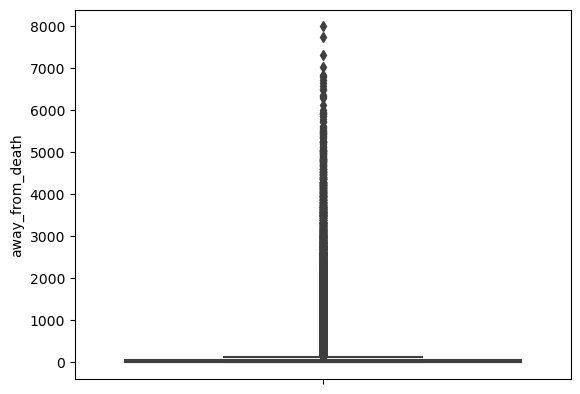

In [40]:
sns.boxplot(data= tidy_dataset, y ='away_from_death')

In [42]:
print(len(tidy_dataset[tidy_dataset["away_from_death"] < 125]))
print(len(tidy_dataset[tidy_dataset["away_from_death"] > 125]))

82306
14882


In [43]:
tidy_dataset['died_within_125days'] = [0] * len(tidy_dataset)

def age_category(data):
    data.loc[(data['away_from_death'] < 125), 'died_within_125days'] = 1
    return data
tidy_dataset = age_category(tidy_dataset)
tidy_dataset

,Internalpatientid,num_visits,CVD,last_visit_date,Age 00-20,Age 20-40,Age 40-60,Age 60-80,Age 80-100,Age 100-120,age_mean,age_std,freq,Died,away_from_death,died_within_125days
0,1,1483,1,2024-07-02 21:13:18,0,0,26,1440,17,0,71.708835,5.016889,64.48,0,NaN,0
0,2,2149,1,2024-04-05 03:30:10,0,0,269,1880,0,0,65.058152,4.662247,93.43,0,NaN,0
0,3,156,0,2005-10-11 09:10:49,0,0,0,87,69,0,79.892190,1.238569,31.20,1,0.0,1
0,4,336,1,2015-02-24 04:43:51,0,0,0,47,289,0,81.903713,3.210646,22.40,1,0.0,1
0,5,124,0,2004-11-04 14:48:32,0,0,0,124,0,0,75.693176,1.203346,17.71,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,169060,1223,1,2017-09-26 11:10:08,0,0,231,992,0,0,65.804712,5.019883,81.53,1,19.0,1
0,169061,119,1,2024-01-29 12:14:06,0,0,0,104,15,0,75.477152,3.898671,5.41,1,17.0,1
0,169062,345,0,2005-10-04 20:08:10,0,0,0,345,0,0,72.124667,1.418916,86.25,1,9.0,1
0,169063,133,0,2006-02-04 23:24:49,0,0,0,133,0,0,75.278206,1.747692,19.00,1,95.0,1


In [ ]:
tidy_dataset.to_csv("/home/hassan/lily/MLA/FDA/outpatient_mortality.csv")